# Neccesary modules 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

In [2]:
background = np.load("data/background_rf_LH_normalized.npy")
drone = np.load("data/drone_rf_LH_normalized.npy")

In [3]:
print(background.shape)
print(drone.shape)

(41, 2, 10000000, 1)
(39, 2, 10000000, 1)


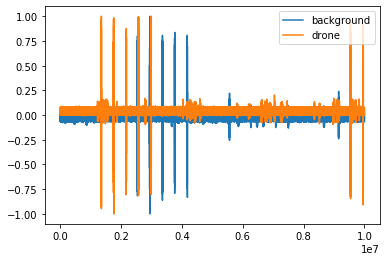

In [6]:
num = random.randint(0, len(background)-1)
channel = random.choice([0,1])
plt.plot(background[num][channel], label="background")
plt.plot(drone[num][channel],label="drone")
plt.legend(loc='upper right')

# Train/ test split and data formatting

In [7]:
Y = np.array([0 for i in enumerate(background)] + [1 for i in enumerate(drone)])
X = np.append(background,drone,axis=0)
Y = Y.reshape(-1,1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
def split_rf(x_data):
    low = []
    high = []
    for x in x_data:
        low.append(x[0].astype(np.float16))
        high.append(x[1].astype(np.float16))
    low = np.array(low)
    high = np.array(high)
    return [low, high]
x_train = split_rf(x_train)
x_test = split_rf(x_test)
    

# Model Specification

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Input

pool_size= 50

# define two sets of inputs
low_rf  = Input(shape=(10000000,1,))
high_rf = Input(shape=(10000000,1,))

# the first branch operates on the first input
x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(low_rf)
x1 = MaxPooling1D(pool_size=pool_size)(x1)
x1 = Conv1D(filters=16, kernel_size=3, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = MaxPooling1D(pool_size=pool_size)(x1)
x1 = Flatten()(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Conv1D(filters=32, kernel_size=3, activation='relu')(high_rf)
x2 = MaxPooling1D(pool_size=pool_size)(x2)
x2 = Conv1D(filters=16, kernel_size=3, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = MaxPooling1D(pool_size=pool_size)(x2)
x2 = Flatten()(x2)
x2 = Dense(50, activation='relu')(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 9999998, 32)  128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 9999998, 32)  128         input_2[0][0]                    
____________________________________________________________________________________________

In [11]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# Train Model

In [12]:
batch_size =1
epochs = 10
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/10
 8/56 [===>..........................] - ETA: 1:37 - loss: 1.2984 - accuracy: 0.4286

ResourceExhaustedError:  OOM when allocating tensor with shape[1,32,9999998,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_2 (defined at /home/NewUsersDir/mohammed/nkalathi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_1784]

Function call stack:
distributed_function


# Evaluate Model

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

InternalError: 2 root error(s) found.
  (0) Internal: Dst tensor is not initialized.
	 [[{{node _arg_input_1_0_0}}]]
	 [[metrics/acc/Identity/_105]]
  (1) Internal: Dst tensor is not initialized.
	 [[{{node _arg_input_1_0_0}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# Train Model

batch_size =1
epochs = 10
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluate Model

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])